# Project 3 Intro
#### Author: Boom D. (DSI-NYC), Mahdi Shadkam-Farrokhi (DSI-NYC)

### Terminology

**API** ("Application Programming Interface"): general set of tools for building software applications.

**Web APIs**: a special class of APIs provided by a website (e.g. Facebook API, Instagram API) that typically require you to go through a series of permission checks to generate an API key. Can use to help us extract data from a particular website

**Web Scraping**: is the process of parsing unstructured HTML to a structured format (Python lists and dictionaries) and leverages some sort of Web API behind the scenes.

### Case Study: Using `requests` to scrape

#### Load Libraries

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import time
import requests
import json
from time import sleep
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.ensemble import RandomForestClassifier

# Load Data

In [2]:
df = pd.read_csv('./data/p3_vegan_nutrit.csv')

In [3]:
df.head()

,Unnamed: 0,text,target
0,0,I gifted SIL an instant pot and would like to ...,vegan
1,1,Are there any recommendations? I tried natural...,vegan
2,2,"In the US, one survey of 11,000 people found t...",vegan
3,3,"And when I say remove I mean remove, help them...",vegan
4,4,[removed],vegan


In [4]:
df.drop(columns = 'Unnamed: 0', inplace = True)

In [5]:
df.head()

,text,target
0,I gifted SIL an instant pot and would like to ...,vegan
1,Are there any recommendations? I tried natural...,vegan
2,"In the US, one survey of 11,000 people found t...",vegan
3,"And when I say remove I mean remove, help them...",vegan
4,[removed],vegan


In [6]:
df.shape

(17266, 2)

In [7]:
df.groupby('target').describe()

text                        
           count unique        top  freq
target                                  
nutrition  12098   2070  [removed]  6468
vegan       5168   2818  [removed]  1532

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17266 entries, 0 to 17265
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    17266 non-null  object
 1   target  17266 non-null  object
dtypes: object(2)
memory usage: 269.9+ KB


# EDA

In [9]:
# check the baseline accuracy
df['target'].value_counts(normalize = True)

nutrition    0.700683
vegan        0.299317
Name: target, dtype: float64

In [10]:
df.groupby('target').describe()

text                        
           count unique        top  freq
target                                  
nutrition  12098   2070  [removed]  6468
vegan       5168   2818  [removed]  1532

In [11]:
df.loc[df['text']=='[removed]',:].index
df.drop(df.loc[df['text']=='[removed]',:].index, inplace = True)

In [12]:
df.groupby('target').describe()

text                       
          count unique        top freq
target                                
nutrition  5630   2069  [deleted]   67
vegan      3636   2817  [deleted]  297

In [13]:
X = df['text']
y = df['target']

In [14]:
# Split the data into the training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.33,
                                                    stratify=y,
                                                    random_state=42)

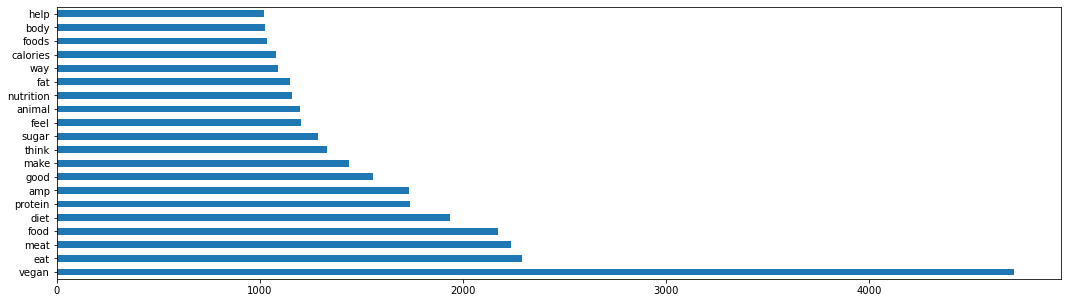

In [53]:
# plotting most repeated words, excluding non-relevant
more_stop = ['just', 'com', 'https', 'know', 'want', 'www', 've','x200b', 'really', 'like', 'don', 'does', 'people', 'lot', 'time', 'day', 'eating', 'going', 'need', 'animals'] 
custom_words = list(ENGLISH_STOP_WORDS) + more_stop



cv = CountVectorizer(stop_words = custom_words, max_features = 600) # ngram_range = (1,2) means i want both 1 and 2 words columns
sparse_mat = cv.fit_transform(df['text']) #fitting the model

all_feature_df = pd.DataFrame(sparse_mat.todense(), columns=cv.get_feature_names()) #attaching column names ie. words
all_feature_df['target'] = y
all_feature_df.drop(columns = 'target').sum().sort_values(ascending=False).head(20).plot(kind='barh', figsize = (18,5));
# remember, these are the lammatized words...

common_words_indicies = all_feature_df.sum().sort_values(ascending=False).head(20).index
# we need the indices because that's what .loc is looking for (or a boolean mask) when I use it below

In [16]:
#custom_words

# Most Frequent Words By Topic

In [17]:
df_nutrit = all_feature_df.loc[all_feature_df['target'] == 'nutrition', :].copy()
df_vegan = all_feature_df.loc[all_feature_df['target'] == 'vegan', :].copy()

In [18]:
print(df_nutrit.shape, df_vegan.shape)

(1873, 601) (3636, 601)


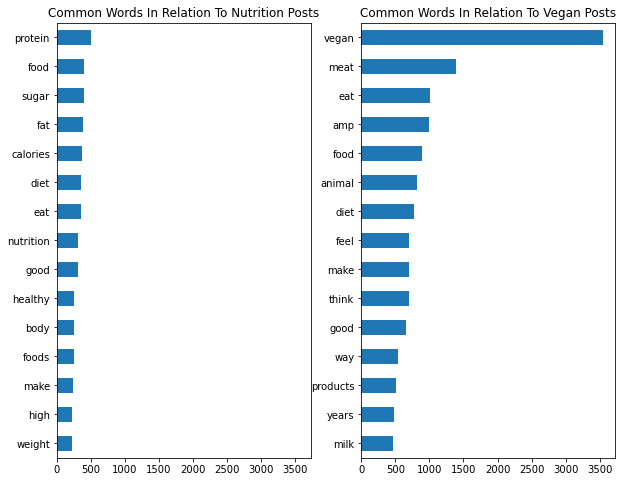

In [19]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (10,8), sharex=True) #last argument to set same scale for x

df_nutrit.drop(columns = 'target').sum().sort_values().tail(15).plot(kind = 'barh',
                                          ax = ax[0], title = 'common words in relation to Nutrition posts'.title());
df_vegan.drop(columns = 'target').sum().sort_values().tail(15).plot(kind = 'barh', ax= ax[1], 
                                        title = 'common words in relation to vegan posts'.title());

# Modeling

In [20]:
#df['target'] = df['target'].map(lambda x: 1 if x == 'vegan' else 0)

In [21]:
df.head()

,text,target
0,I gifted SIL an instant pot and would like to ...,vegan
1,Are there any recommendations? I tried natural...,vegan
2,"In the US, one survey of 11,000 people found t...",vegan
3,"And when I say remove I mean remove, help them...",vegan
6,Meat,vegan


# Creating models and Pipes & GridSearching on each & fitting & finding best score:

In [22]:
# look for the best score
cv_log_pipe = Pipeline([('vector', CountVectorizer()), ('logreg', LogisticRegression())])
cv_log_params = {
    'logreg__solver': ['liblinear'], 
    'vector__min_df' : [3,4,8],
    'vector__stop_words' : [custom_words, None],
    'logreg__penalty' : ['l1', 'l2'],
    'logreg__C' : [.1, 5, 50]
}
cv_log_gs = GridSearchCV(cv_log_pipe, cv_log_params, cv = 5, verbose=0)
cv_log_gs.fit(X_train, y_train)

C:\Users\gc\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('vector', CountVectorizer()),
                                       ('logreg', LogisticRegression())]),
             param_grid={'logreg__C': [0.1, 5, 50],
                         'logreg__penalty': ['l1', 'l2'],
                         'logreg__solver': ['liblinear'],
                         'vector__min_df': [3, 4, 8],
                         'vector__stop_words': [['during', 'only', 'eg', 'so',
                                                 'twenty', 'keep', 'off',
                                                 'please', 'except', 'again',
                                                 'beside', 'perhaps',
                                                 'otherwise', 'she', 'in', 'of',
                                                 'besides', 'without', 'move',
                                                 'against', 'thin', 'then',
                                                 'what', 'seemed', 'had',
   

In [23]:
tf_log_pipe = Pipeline([('tfdf', TfidfVectorizer()),('logreg', LogisticRegression())])
tf_log_params = {
    'logreg__solver': ['liblinear'], 
    'tfdf__stop_words' : [custom_words, None],
    'logreg__C' : [.1, 5, 50]
}
tf_log_gs = GridSearchCV(tf_log_pipe, tf_log_params, cv = 5, verbose=0)
tf_log_gs.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfdf', TfidfVectorizer()),
                                       ('logreg', LogisticRegression())]),
             param_grid={'logreg__C': [0.1, 5, 50],
                         'logreg__solver': ['liblinear'],
                         'tfdf__stop_words': [['during', 'only', 'eg', 'so',
                                               'twenty', 'keep', 'off',
                                               'please', 'except', 'again',
                                               'beside', 'perhaps', 'otherwise',
                                               'she', 'in', 'of', 'besides',
                                               'without', 'move', 'against',
                                               'thin', 'then', 'what', 'seemed',
                                               'had', 'throughout', 'together',
                                               'behind', 'de', 'back', ...],
                              

In [24]:
# 
tf_nb_pipe = Pipeline([('tfdf', TfidfVectorizer()),('naive', MultinomialNB())])
tf_nb_params = {
    'tfdf__stop_words' : [custom_words, None],
    'naive__alpha' : [0.001, 0.01, 0.1, 0.5, 0.8]
}
tf_nb_gs = GridSearchCV(tf_nb_pipe, tf_nb_params, cv = 5, verbose=0)
tf_nb_gs.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfdf', TfidfVectorizer()),
                                       ('naive', MultinomialNB())]),
             param_grid={'naive__alpha': [0.001, 0.01, 0.1, 0.5, 0.8],
                         'tfdf__stop_words': [['during', 'only', 'eg', 'so',
                                               'twenty', 'keep', 'off',
                                               'please', 'except', 'again',
                                               'beside', 'perhaps', 'otherwise',
                                               'she', 'in', 'of', 'besides',
                                               'without', 'move', 'against',
                                               'thin', 'then', 'what', 'seemed',
                                               'had', 'throughout', 'together',
                                               'behind', 'de', 'back', ...],
                                              None]})

In [25]:
## Random Forest Model
cv = CountVectorizer(stop_words = custom_words)
X_train_cv = cv.fit_transform(X_train)

In [26]:
forest = RandomForestClassifier()
forest_params = {
    'n_estimators' : [5, 10, 15, 20],
    'max_depth' : [10, 20, 30],
    'max_features' : [.2, .3]
}
gs_forest = GridSearchCV(forest, param_grid = forest_params, cv = 5)
gs_forest.fit(X_train_cv, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [10, 20, 30], 'max_features': [0.2, 0.3],
                         'n_estimators': [5, 10, 15, 20]})

In [27]:
print('best score of random foresets is: ',gs_forest.best_score_.round(4))
print('best score of CountVectorizer with Logistic Regression is:', cv_log_gs.best_score_.round(4))
#print('best score of CountVectorizer with naive multinomial Bayes is:', cv_nb_gs.best_score_.round(4))
print('best score of TFDIF with Logistic Regression is:', tf_log_gs.best_score_.round(4))
print('best score of TFDIF with naive multinomial Bayes is:', tf_nb_gs.best_score_.round(4))

best score of random foresets is:  0.9187
best score of CountVectorizer with Logistic Regression is: 0.9352
best score of TFDIF with Logistic Regression is: 0.9414
best score of TFDIF with naive multinomial Bayes is: 0.9187


In [28]:
print('best score of random foresets is: ',gs_forest.best_params_)

best score of random foresets is:  {'max_depth': 30, 'max_features': 0.2, 'n_estimators': 20}


In [29]:
## the winner is TFDIF with Logistic Regression, so we're gonna fit that one
# fininding best estimators of the winning model to use them: 
print(tf_log_gs.best_estimator_.get_params()['steps'])

[('tfdf', TfidfVectorizer()), ('logreg', LogisticRegression(C=50, solver='liblinear'))]


# This shows overfit.  Try to improve it by hyperparameter

In [30]:
# fit the winning model and vectorizer
tf = TfidfVectorizer(stop_words = custom_words)

X_train_tf = tf.fit_transform(X_train)
X_test_tf = tf.transform(X_test)
print(X_train_tf.shape)

(6208, 17621)


In [31]:

logreg = LogisticRegression(C = 50, penalty = 'l2', solver = 'liblinear') #l2 is Ridge (google: 'l1 ridge or lasso?')
logreg.fit(X_train_tf, y_train)
preds = logreg.predict(X_test_tf)

In [32]:
print('accuracy score of TFDIF and Logistic on testing data: ', logreg.score(X_test_tf, y_test).round(4))
print('cross-validation score is: ', \
    cross_val_score(logreg, X_train_tf, y_train, cv = 5).mean().round(4)) 
#this cross-val score is how we expect the model to perform on unseen data

accuracy score of TFDIF and Logistic on testing data:  0.9379
cross-validation score is:  0.936


In [33]:
# extra making sure it's not overfitting, by scoring it on train and test dataset
print('on training set, score is: ', tf_log_gs.score(X_train, y_train).round(4))
print('on testing set, score is: ', tf_log_gs.score(X_test, y_test).round(4))

on training set, score is:  0.9915
on testing set, score is:  0.9408


# Confusion Matrix and Classification Report

In [34]:
confusion_matrix(y_test, preds)
print('classification report', classification_report(y_test, preds))

classification report               precision    recall  f1-score   support

   nutrition       0.93      0.98      0.95      1858
       vegan       0.96      0.88      0.92      1200

    accuracy                           0.94      3058
   macro avg       0.94      0.93      0.93      3058
weighted avg       0.94      0.94      0.94      3058



In [54]:
# Generate confusion matrix.
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

print(confusion_matrix(y_test, preds))

[[1813   45]
 [ 145 1055]]


In [55]:
# Calculate sensitivity.

sens = tp / (tp + fn)

print(f'Sensitivity: {round(sens, 4)}')

Sensitivity: 0.8792


In [56]:
# Calculate specificity.

spec = tn / (tn + fp)

print(f'Specificity: {round(spec, 4)}')

Specificity: 0.9758


In [57]:
# to make confusion matrix look nicer: 
col_names = ['Predicted ' + i for i in df['target'].value_counts().index]
index_names = ['Actual ' + i for i in df['target'].value_counts().index]
cm = pd.DataFrame(confusion_matrix(y_test, preds), columns = col_names, index = index_names )
cm

,Predicted nutrition,Predicted vegan
Actual nutrition,1813,45
Actual vegan,145,1055


# obtain coefficients of the winning model and visualize them by plotting

In [39]:
tf_log_gs.best_estimator_.steps[1][1].coef_ # same as logreg.coef_

array([[-0.92897269,  0.64556961, -0.06555062, ...,  0.02099417,
         0.02099417,  0.02099417]])

In [40]:
# making coeficients into a dataframe to plot them
coef_df = pd.DataFrame(logreg.coef_, columns = tf.get_feature_names()).T.sort_values(by = 0).head(15)
coef_df['abs'] = coef_df[0].abs()
coef_df.sort_values(by = 'abs', ascending = False).head(15)

,0,abs
nutrition,-16.136241,16.136241
healthy,-12.046182,12.046182
true,-10.093898,10.093898
calories,-9.656086,9.656086
subreddit,-8.969118,8.969118
exist,-8.531687,8.531687
nutritional,-7.592125,7.592125
healthier,-6.202305,6.202305
bad,-6.187752,6.187752
serving,-5.919852,5.919852


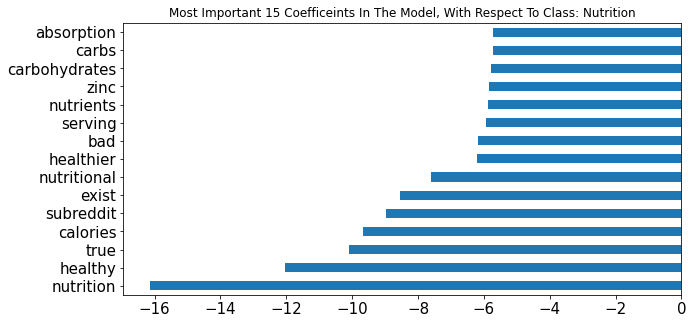

In [41]:
# plotting most important coefficients: 
coef_df.sort_values(by = 'abs', ascending = False).head(15)[0].plot(kind = 'barh', figsize = (10,5), title = "most \
important 15 coefficeints in the model, with respect to class: nutrition".title(), fontsize = 15);

# Create the image of the most common words for visual appeal

In [64]:
import wordcloud

In [65]:
common_words = all_feature_df.sum().sort_values(ascending=False).head(20) # this is a series of words and their count
list(common_words.index)
common_words = ' '.join(list(common_words.index))

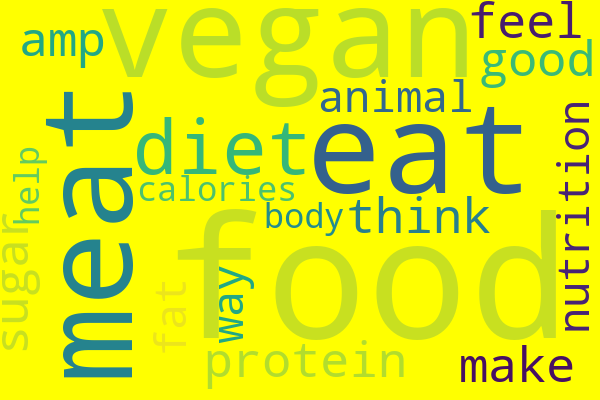

In [66]:
wc = wordcloud.WordCloud(background_color='yellow', max_words=75, width=600, height =400)
# adding stop words will put only the stop words, not eliminate them.
cloud = wc.generate(common_words)
cloud.to_image()